### Prepare scRNA-seq for spatial-sc model

In [2]:
import numpy as np
import pandas as pd
import scipy, sklearn
import matplotlib.pyplot as plt
import scanpy as sc
import loompy
from scipy.sparse import csr_matrix
import h5py
import anndata

### scRNA-seq data from La Manno et al. 2021

In [2]:
gene_subset = pd.read_csv('../data/spat_gene_names.csv', header=None)[0]
gene_subset.head()

0      Agt
1    Aldoc
2     Ano1
3     Aqp4
4    Atoh1
Name: 0, dtype: object

In [3]:
# Load Loom file (takes a long time)
scrna_dat = sc.read_loom("../../../2209_hybiss_deconvolution/data/l5_all.loom")

/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2209_hybiss_deconvolution/2209_env/lib/python3.7/site-packages/anndata/_io/read.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  axis_df[k] = v
/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2209_hybiss_deconvolution/2209_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2209_hybiss_deconvolution/2209_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# We subset to use only genes in the subset coming from spatial expression data
scrna_dat_sub = scrna_dat[:,scrna_dat.var_names.isin(gene_subset)]

In [53]:
# Handling duplicate genes in scRNA-seq data
non_unique_gene_names = np.unique(scrna_dat_sub.var_names, return_counts=True)[0][np.unique(scrna_dat_sub.var_names, return_counts=True)[1] > 1]
scrna_dat_sub = scrna_dat_sub[:,~scrna_dat_sub.var_names.duplicated(keep='first')]

In [97]:
# check if any non-unique gene names is present
len(np.unique(scrna_dat_sub.var_names, return_counts=True)[0][np.array(np.unique(scrna_dat_sub.var_names, return_counts=True)[1] > 1)])

0

Here is all the information about clustering we have from the scRNA-seq data:

In [63]:
scrna_dat_sub.obs[['Class', 'ClusterName', 'Clusters', 'TaxonomyRank1', 'TaxonomyRank2',
                   'TaxonomyRank3', 'TaxonomyRank4', 'TaxonomySymbol',
                   'Taxonomy_group']].head(3)

,Class,ClusterName,Clusters,TaxonomyRank1,TaxonomyRank2,TaxonomyRank3,TaxonomyRank4,TaxonomySymbol,Taxonomy_group
CellID,,,,,,,,,
10X82_2_TCTCTCACCAGTTA-,Neurons,ENT9,0,Neurons,PNS neurons,Enteric neurons,Enteric neurons,Enne,Enteric neurons
10X82_2_TATTATCTACCAGA-,Neurons,ENT9,0,Neurons,PNS neurons,Enteric neurons,Enteric neurons,Enne,Enteric neurons
10X82_2_TATCCCAGATGGCA-,Neurons,ENT9,0,Neurons,PNS neurons,Enteric neurons,Enteric neurons,Enne,Enteric neurons


We will rely on `Class`, `Clusters`, `TaxonomyRank1`, `TaxonomyRank2`, `TaxonomyRank3`, and `TaxonomyRank4` groupings. All are derived from 265 `Clusters`.

In [96]:
taxonomy_ranks = ['Class','Clusters','TaxonomyRank1','TaxonomyRank2','TaxonomyRank3','TaxonomyRank4']
for taxonomy in taxonomy_ranks:
    print(taxonomy)
    n_groups = len(np.unique(scrna_dat_sub.obs[taxonomy])) # number of clusters
    
    # iterate over clusters and compute the mean expression over cells belonging to group 'g'
    cell_types = np.unique(scrna_dat_sub.obs[taxonomy])
    mu_list = [] # record in list
    for k in cell_types:
        mu_list.append(np.array(scrna_dat_sub[scrna_dat_sub.obs[taxonomy].isin([k]),:].X.mean(axis=0))[0,:])
    # assemble results in pandas with group names and gene names
    mu_X = pd.DataFrame(np.array(mu_list), index = cell_types, columns = scrna_dat_sub.var_names).T
    mu_X.to_csv(f"../data/scrna_muX_clust{n_groups}_{taxonomy}.csv")

Class
Clusters
TaxonomyRank1
TaxonomyRank2
TaxonomyRank3
TaxonomyRank4


Hereafter, how the different Taxonomy relates to each other.

In [117]:
np.unique(scrna_dat.obs.TaxonomyRank1 + '_' + scrna_dat.obs.TaxonomyRank2 + '_' + scrna_dat.obs.TaxonomyRank3 + '_' + scrna_dat.obs.TaxonomyRank4)

array(['Glia_CNS glia_Astroependymal cells_Astrocytes',
       'Glia_CNS glia_Astroependymal cells_Choroid epithelial cells',
       'Glia_CNS glia_Astroependymal cells_Dentate gyrus radial glia-like cells',
       'Glia_CNS glia_Astroependymal cells_Ependymal cells',
       'Glia_CNS glia_Astroependymal cells_Subcommissural organ hypendymal cells',
       'Glia_CNS glia_Astroependymal cells_Subventricular zone radial glia-like cells',
       'Glia_CNS glia_Oligodendrocytes_Oligodendrocytes',
       'Glia_Neural crest-like glia_Neural crest-like glia_Enteric glia',
       'Glia_Neural crest-like glia_Neural crest-like glia_Olfactory ensheathing cells',
       'Glia_Neural crest-like glia_Neural crest-like glia_Oligodendrocyte precursor cells',
       'Glia_Neural crest-like glia_Neural crest-like glia_Satellite glia',
       'Glia_Neural crest-like glia_Neural crest-like glia_Schwann cells',
       'Immune cells_Immune cells_Immune cells_Microglia',
       'Immune cells_Immune cells_Im

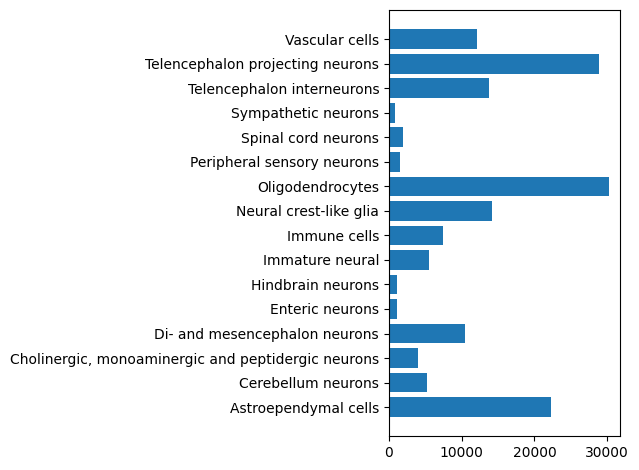

In [29]:
plt.barh(np.unique(scrna_dat_sub.obs['TaxonomyRank3']), 
         np.unique(scrna_dat_sub.obs['TaxonomyRank3'], return_counts=True)[1])
plt.tight_layout()
plt.savefig("../results/figs/scrna_celltype_abundance.pdf", dpi=300)

In [27]:
pd.DataFrame(np.unique(scrna_dat_sub.obs['TaxonomyRank1'], return_counts=True), index=['name', 'count']).T.to_csv("../data/scrna_cellProp_TaxonomyRank1.csv")
pd.DataFrame(np.unique(scrna_dat_sub.obs['TaxonomyRank2'], return_counts=True), index=['name', 'count']).T.to_csv("../data/scrna_cellProp_TaxonomyRank2.csv")
pd.DataFrame(np.unique(scrna_dat_sub.obs['TaxonomyRank3'], return_counts=True), index=['name', 'count']).T.to_csv("../data/scrna_cellProp_TaxonomyRank3.csv")
pd.DataFrame(np.unique(scrna_dat_sub.obs['TaxonomyRank4'], return_counts=True), index=['name', 'count']).T.to_csv("../data/scrna_cellProp_TaxonomyRank4.csv")

### scRNA-seq data from Yao et al. 2021

In [3]:
hf = h5py.File('../data/xenium/xenium_scrna_reference_yao2021/CTX_Hip_counts_10x.h5', 'r')

In [ ]:
counts = csr_matrix(np.array(hf.get('data').get('counts')))